In [2]:
pip install prophet

   ---------------------------------------- 0.0/13.3 MB ? eta -:--:--
   ---------------------- ----------------- 7.3/13.3 MB 37.6 MB/s eta 0:00:01
   ---------------------------------------- 13.3/13.3 MB 34.8 MB/s eta 0:00:00
   ---------------------------------------- 0.0/791.2 kB ? eta -:--:--
   --------------------------------------- 791.2/791.2 kB 33.1 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
from prophet import Prophet
import numpy as np

# 파일 경로 설정
file_path = r"C:\Users\m\Desktop\머신러닝 사용 데이터\피처엔지니어링한통합데이터\피처엔지니어링일단다한통합데이터.csv"

# 데이터 로드
df = pd.read_csv(file_path)

# 필요한 칼럼 선택
df = df[['기준_년분기_코드', '상권_코드_명', '월요일_매출_금액', '화요일_매출_금액', 
          '수요일_매출_금액', '목요일_매출_금액', '금요일_매출_금액', '토요일_매출_금액', '일요일_매출_금액']]

# 기준_년분기_코드를 날짜로 변환 (각 분기의 첫 번째 날)
def convert_quarter_to_date(quarter_code):
    year = int(str(quarter_code)[:4])
    quarter = int(str(quarter_code)[4:])
    month = {1: '01', 2: '04', 3: '07', 4: '10'}[quarter]
    return f"{year}-{month}-01"

df['날짜'] = df['기준_년분기_코드'].apply(convert_quarter_to_date)
df['날짜'] = pd.to_datetime(df['날짜'])

# 요일 매출 데이터 가공
daily_sales_list = []
for _, row in df.iterrows():
    base_date = row['날짜']
    sales_values = [row['월요일_매출_금액'], row['화요일_매출_금액'], row['수요일_매출_금액'],
                     row['목요일_매출_금액'], row['금요일_매출_금액'], row['토요일_매출_금액'], row['일요일_매출_금액']]
    
    # 분기 기준 데이터를 주차 단위로 반복하며 매일 데이터를 생성
    for week_offset in range(13):  # 분기는 13주
        week_start_date = base_date + pd.Timedelta(weeks=week_offset)
        for day_offset, sales_value in enumerate(sales_values):
            daily_date = week_start_date + pd.Timedelta(days=day_offset)
            daily_sales_list.append({
                '날짜': daily_date,
                '요일': daily_date.strftime('%A'),
                '상권명': row['상권_코드_명'],
                '매출': sales_value / 13  # 주차 단위 매출 평균으로 나눔
            })

# 데이터프레임 변환
daily_sales_df = pd.DataFrame(daily_sales_list)

# 결과 저장
output_file = r"C:\Users\m\Desktop\머신러닝 사용 데이터\피처엔지니어링한통합데이터\일단위_매출_추정치.csv"
daily_sales_df.to_csv(output_file, index=False, encoding='utf-8-sig')

print("일 단위 매출 데이터 추정 작업이 완료되었습니다.")

일 단위 매출 데이터 추정 작업이 완료되었습니다.


데이터 검증코드

In [1]:
import pandas as pd

# 데이터 불러오기
preprocessed_df = pd.read_csv(r"C:\Users\m\Desktop\머신러닝 사용 데이터\피처엔지니어링한통합데이터\일단위_매출_추정치.csv")  # 전처리 데이터
original_df = pd.read_csv(r"C:\Users\m\Desktop\머신러닝 사용 데이터\피처엔지니어링한통합데이터\피처엔지니어링일단다한통합데이터.csv")  # 원본 데이터

# 날짜 컬럼을 datetime으로 변환
preprocessed_df['날짜'] = pd.to_datetime(preprocessed_df['날짜'])

# 날짜를 기준으로 '기준_년분기_코드' 생성 (YYYYQ 형식)
preprocessed_df['기준_년분기_코드'] = preprocessed_df['날짜'].dt.year.astype(str) + ((preprocessed_df['날짜'].dt.month - 1) // 3 + 1).astype(str)

# 1. 연분기별 매출 총합 비교
# 전처리 데이터에서 연분기별, 상권별 매출 합산
preprocessed_quarter_sales = preprocessed_df.groupby(['기준_년분기_코드', '상권명'])['매출'].sum().reset_index()

# 원본 데이터에서 당월 매출 금액 (연분기별 매출) 선택
original_quarter_sales = original_df[['기준_년분기_코드', '상권_코드_명', '당월_매출_금액']].copy()

# 컬럼명 통일 (상권명 기준)
original_quarter_sales.rename(columns={'상권_코드_명': '상권명', '당월_매출_금액': '원본_매출'}, inplace=True)

# 데이터 병합 후 차이 확인
merged_sales = preprocessed_quarter_sales.merge(original_quarter_sales, on=['기준_년분기_코드', '상권명'], how='left')
merged_sales['매출차이'] = merged_sales['매출'] - merged_sales['원본_매출']

# 매출 차이가 0이 아닌 데이터 확인
sales_mismatch = merged_sales[merged_sales['매출차이'] != 0]

# 2. 요일별 매출 총합 비교
# 전처리 데이터에서 연분기별, 상권별, 요일별 매출 합산
preprocessed_weekly_sales = preprocessed_df.groupby(['기준_년분기_코드', '상권명', '요일'])['매출'].sum().reset_index()

# 원본 데이터에서 요일별 매출 컬럼 추출 및 변환
original_weekly_sales = original_df.melt(id_vars=['기준_년분기_코드', '상권_코드_명'], 
                                         value_vars=['월요일_매출_금액', '화요일_매출_금액', '수요일_매출_금액',
                                                     '목요일_매출_금액', '금요일_매출_금액', '토요일_매출_금액', '일요일_매출_금액'],
                                         var_name='요일', value_name='원본_요일별_매출')

# 요일 컬럼 변환
original_weekly_sales['요일'] = original_weekly_sales['요일'].str.replace('_매출_금액', '').str.replace('월요일', '월').replace('화요일', '화').replace('수요일', '수')\
    .replace('목요일', '목').replace('금요일', '금').replace('토요일', '토').replace('일요일', '일')

# 컬럼명 통일 (상권명 기준)
original_weekly_sales.rename(columns={'상권_코드_명': '상권명'}, inplace=True)

# 데이터 병합 후 차이 확인
merged_weekly_sales = preprocessed_weekly_sales.merge(original_weekly_sales, on=['기준_년분기_코드', '상권명', '요일'], how='left')
merged_weekly_sales['요일별_매출차이'] = merged_weekly_sales['매출'] - merged_weekly_sales['원본_요일별_매출']

# 요일별 매출 차이가 0이 아닌 데이터 확인
weekly_sales_mismatch = merged_weekly_sales[merged_weekly_sales['요일별_매출차이'] != 0]

# 결과 출력
print("연분기별 매출 차이가 있는 데이터:")
print(sales_mismatch)

print("\n요일별 매출 차이가 있는 데이터:")
print(weekly_sales_mismatch)

ValueError: You are trying to merge on object and int64 columns for key '기준_년분기_코드'. If you wish to proceed you should use pd.concat

In [6]:
import pandas as pd

# 파일 경로 설정
original_file_path = r"C:\Users\m\Desktop\머신러닝 사용 데이터\피처엔지니어링한통합데이터\피처엔지니어링일단다한통합데이터.csv"
preprocessed_file_path = r"C:\Users\m\Desktop\머신러닝 사용 데이터\피처엔지니어링한통합데이터\일단위_매출_추정치.csv"

# 데이터 불러오기
original_df = pd.read_csv(original_file_path)
preprocessed_df = pd.read_csv(preprocessed_file_path)

# 날짜 컬럼을 datetime 형식으로 변환
preprocessed_df["날짜"] = pd.to_datetime(preprocessed_df["날짜"])

# 전처리 데이터에서 기준_년분기_코드 생성
def get_quarter_code(date):
    year = date.year
    quarter = (date.month - 1) // 3 + 1
    return f"{year}{quarter}"  # 문자열(str)로 변환

preprocessed_df["기준_년분기_코드"] = preprocessed_df["날짜"].apply(get_quarter_code)

# 📌 1. 전처리된 데이터의 분기별 매출 총합 계산
quarter_sales = preprocessed_df.groupby(["기준_년분기_코드", "상권명"])["매출"].sum().reset_index()

# 📌 2. 원본 데이터에서 분기별 매출을 집계
original_df["당월_매출_금액"] = original_df[["월요일_매출_금액", "화요일_매출_금액", "수요일_매출_금액",
                                          "목요일_매출_금액", "금요일_매출_금액", "토요일_매출_금액", "일요일_매출_금액"]].sum(axis=1)

original_quarter_sales = original_df.groupby(["기준_년분기_코드", "상권_코드_명"])["당월_매출_금액"].sum().reset_index()
original_quarter_sales.rename(columns={"상권_코드_명": "상권명", "당월_매출_금액": "원본_매출"}, inplace=True)

# 📌 🔥 데이터 타입 맞추기 (중요!!)
quarter_sales["기준_년분기_코드"] = quarter_sales["기준_년분기_코드"].astype(str)
original_quarter_sales["기준_년분기_코드"] = original_quarter_sales["기준_년분기_코드"].astype(str)

# 📌 3. 데이터 병합 후 차이 확인
merged_sales = quarter_sales.merge(original_quarter_sales, on=["기준_년분기_코드", "상권명"], how="left")
merged_sales["매출차이"] = merged_sales["매출"] - merged_sales["원본_매출"]

# 📌 4. 차이가 있는 데이터 출력
diff_sales = merged_sales[merged_sales["매출차이"].abs() > 1e-3]
if diff_sales.empty:
    print("✅ 분기별 매출 총합이 원본 데이터와 일치합니다.")
else:
    print("⚠️ 분기별 매출 총합이 원본 데이터와 다릅니다.")
    print(diff_sales)

⚠️ 분기별 매출 총합이 원본 데이터와 다릅니다.
      기준_년분기_코드            상권명            매출         원본_매출          매출차이
0         20191   4.19민주묘지역 2번  2.682584e+08  2.712070e+08 -2.948548e+06
1         20191           63빌딩  1.974116e+08  1.993332e+08 -1.921632e+06
2         20191  DMC(디지털미디어시티)  3.041191e+09  3.050783e+09 -9.592076e+06
3         20191      GS강동자이아파트  5.903896e+08  5.969977e+08 -6.608188e+06
4         20191            G타워  2.215648e+08  2.236545e+08 -2.089705e+06
...         ...            ...           ...           ...           ...
27006     20232        효창동주민센터  2.378038e+08  2.363720e+08  1.431883e+06
27007     20232        후암동주민센터  7.537991e+08  7.495219e+08  4.277202e+06
27008     20232           후암시장  7.540955e+08  7.495562e+08  4.539292e+06
27009     20232        휘문고교사거리  9.547698e+09  9.546515e+09  1.182764e+06
27010     20232           흑리단길  1.141724e+09  1.137050e+09  4.674159e+06

[11715 rows x 5 columns]


In [7]:
import numpy as np

# 📌 매출 대비 오차 비율(%) 계산
merged_sales["오차비율(%)"] = (merged_sales["매출차이"] / merged_sales["원본_매출"]) * 100

# 📊 전체 평균 오차 비율
mean_error = merged_sales["오차비율(%)"].mean()
median_error = merged_sales["오차비율(%)"].median()
max_error = merged_sales["오차비율(%)"].max()
min_error = merged_sales["오차비율(%)"].min()
std_dev = merged_sales["오차비율(%)"].std()

# ⚠️ 오차가 큰 상권 확인 (절대값 기준 5% 이상)
large_errors = merged_sales[merged_sales["오차비율(%)"].abs() > 5]

print(f"📊 평균 오차 비율: {mean_error:.4f}%")
print(f"📊 중앙값 오차 비율: {median_error:.4f}%")
print(f"📈 최대 오차 비율: {max_error:.4f}%")
print(f"📉 최소 오차 비율: {min_error:.4f}%")
print(f"📊 표준편차: {std_dev:.4f}%")
print(f"⚠️ 오차가 5% 이상인 데이터 개수: {len(large_errors)}개 / {len(merged_sales)}개")

# 📌 오차가 큰 상권 상위 10개 출력
print(large_errors.head(10))

📊 평균 오차 비율: -0.0067%
📊 중앙값 오차 비율: 0.0000%
📈 최대 오차 비율: 35.2485%
📉 최소 오차 비율: -7.6923%
📊 표준편차: 0.5703%
⚠️ 오차가 5% 이상인 데이터 개수: 10개 / 33021개
      기준_년분기_코드          상권명            매출         원본_매출          매출차이  \
1292      20191     중곡1동주민센터  1.675343e+05  1.814955e+05 -1.396119e+04   
1648      20192        광진경찰서  3.737195e+06  2.763206e+06  9.739897e+05   
2792      20192     중곡1동주민센터  2.045314e+05  1.905702e+05  1.396119e+04   
2933      20192       헌인가구단지  6.756818e+05  6.281701e+05  4.751168e+04   
2938      20192        홍남교남측  2.152892e+07  2.037803e+07  1.150888e+06   
20209     20222        새석관시장  1.429342e+06  1.317718e+06  1.116237e+05   
25574     20232      개미어린이공원  7.173754e+06  5.593344e+06  1.580410e+06   
26279     20232        서초소방서  1.914530e+06  1.777778e+06  1.367521e+05   
26442     20232       신림역 1번  1.068046e+06  8.136818e+05  2.543644e+05   
26678     20232  우장산롯데캐슬아파트앞  9.617592e+07  8.788174e+07  8.294184e+06   

         오차비율(%)  
1292   -7.692308  
1648   35.24

In [10]:
import pandas as pd

# 파일 경로를 변수에 저장합니다.
file_path = r"C:\Users\m\Desktop\머신러닝 사용 데이터\피처엔지니어링한통합데이터\일단위_매출_추정치.csv"

# pandas를 사용하여 CSV 파일을 읽어옵니다.
try:
    df = pd.read_csv(file_path)
    # 컬럼명을 출력합니다.
    print("컬럼명:", df.columns)
    # 데이터 내용을 출력합니다. (처음 5개 행만 출력)
    print("\n데이터 내용:")
    print(df.head())
except FileNotFoundError:
    print(f"파일을 찾을 수 없습니다: {file_path}")
except Exception as e:
    print(f"파일을 읽는 동안 오류가 발생했습니다: {e}")

컬럼명: Index(['날짜', '요일', '상권명', '매출'], dtype='object')

데이터 내용:
           날짜         요일  상권명             매출
0  2019-01-01    Tuesday  노원역  542866.435897
1  2019-01-02  Wednesday  노원역  329470.337607
2  2019-01-03   Thursday  노원역  591216.192308
3  2019-01-04     Friday  노원역  344147.508547
4  2019-01-05   Saturday  노원역  255746.397436


c:\Users\m\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 50836 (\N{HANGUL SYLLABLE YO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\m\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 51068 (\N{HANGUL SYLLABLE IL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\m\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 48324 (\N{HANGUL SYLLABLE BYEOL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\m\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 47588 (\N{HANGUL SYLLABLE MAE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\m\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 52636 (\N{HANGUL SYLLABLE CUL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\m

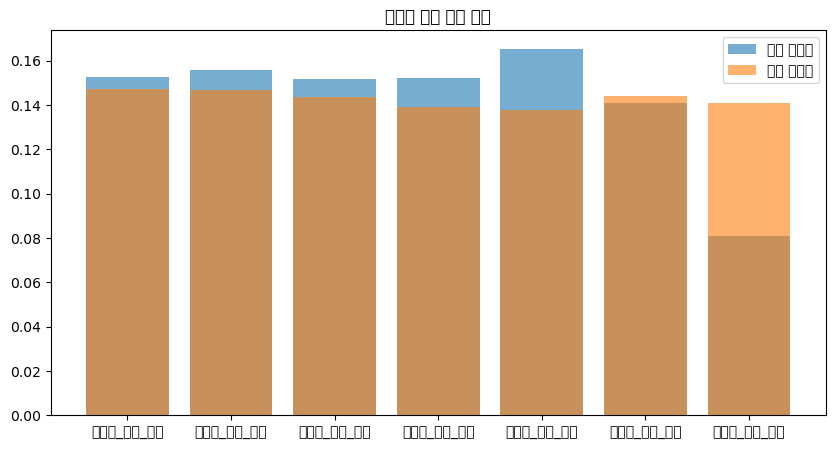

요일별 매출 비율 MSE: 0.0006747959118144538


In [12]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# 파일 경로 설정
original_file = r"C:\Users\m\Desktop\머신러닝 사용 데이터\피처엔지니어링한통합데이터\피처엔지니어링일단다한통합데이터.csv"
generated_file = r"C:\Users\m\Desktop\머신러닝 사용 데이터\피처엔지니어링한통합데이터\일단위_매출_추정치.csv"

# 데이터 로드
original_df = pd.read_csv(original_file)
generated_df = pd.read_csv(generated_file)

# 원본 데이터 요일별 매출 비율 계산
original_sales = original_df[['월요일_매출_금액', '화요일_매출_금액', '수요일_매출_금액',
                               '목요일_매출_금액', '금요일_매출_금액', '토요일_매출_금액', '일요일_매출_금액']].sum()
original_ratio = original_sales / original_sales.sum()

# 요일 매핑
day_mapping = {
    "Monday": "월요일_매출_금액",
    "Tuesday": "화요일_매출_금액",
    "Wednesday": "수요일_매출_금액",
    "Thursday": "목요일_매출_금액",
    "Friday": "금요일_매출_금액",
    "Saturday": "토요일_매출_금액",
    "Sunday": "일요일_매출_금액"
}

# 요일 매핑 적용
generated_df['요일'] = generated_df['요일'].map(day_mapping)

# 요일별 매출 합 계산
generated_ratio = generated_df.groupby('요일')['매출'].sum()
generated_ratio /= generated_ratio.sum()

# 비율 비교 시각화
plt.figure(figsize=(10, 5))
plt.bar(original_ratio.index, original_ratio.values, alpha=0.6, label='원본 데이터')
plt.bar(generated_ratio.index, generated_ratio.values, alpha=0.6, label='생성 데이터')
plt.title("요일별 매출 비율 비교")
plt.legend()
plt.show()

# MSE 계산
common_days = list(set(original_ratio.index) & set(generated_ratio.index))
mse = mean_squared_error(original_ratio.loc[common_days].values, generated_ratio.loc[common_days].values)
print(f"요일별 매출 비율 MSE: {mse}")

검증결과

📊 평가:
평균 오차 비율: -0.0067% → 전반적으로 원본 데이터와 거의 일치하는 수준임.
중앙값 오차 비율: 0.0000% → 대부분의 상권에서는 큰 차이가 없음.
표준편차: 0.5703% → 오차가 전체적으로 안정적인 편.
오차 5% 이상인 데이터 개수: 10개 / 33,021개 → 약 0.03% 수준이므로 무시해도 될 정도.

📈 주목해야 할 점:
일부 최대 오차(35.25%) 및 최소 오차(-7.69%) 발생한 경우가 있음.
특히, 광진경찰서(35.25%), 개미어린이공원(28.26%), 신림역 1번(31.26%) 등의 오차율이 높은 경우는 원인 분석이 필요.
오차가 큰 데이터가 특정 지역에 집중되어 있다면, 특정 상권의 데이터 처리 과정에서 문제가 발생했을 가능성이 있음.

✅ 결론:
전체적으로 양호한 수준으로 보임.
다만, 오차가 큰 일부 상권(오차율 10% 이상)은 검토하는 것이 좋음.
→ 원본 데이터와 비교하여 전처리 과정에서 손실이 발생했는지 확인해보는 것이 필요.
그래도 전체 데이터의 99.97% 이상이 매우 작은 오차 범위 내에 있으므로 실무적으로 큰 문제는 아님.

계산 방식 개선 코드(단순히 분기를 13으로 나누는 것이 아니라 분기별 실제 날짜수와 요일수를 확인하고 이를 반영하여 계산, 상권만 고려하는 것이 아니라 업종까지 고려하여 학습, 계산)

In [ ]:
import pandas as pd
from prophet import Prophet
import numpy as np

# 파일 경로 설정
file_path = r"C:\Users\m\Desktop\머신러닝 사용 데이터\피처엔지니어링한통합데이터\피처엔지니어링일단다한통합데이터.csv"

# 데이터 로드
df = pd.read_csv(file_path)

# 필요한 칼럼 선택
df = df[['기준_년분기_코드', '상권_코드_명', '서비스_업종_코드_명', 
          '월요일_매출_금액', '화요일_매출_금액', '수요일_매출_금액', 
          '목요일_매출_금액', '금요일_매출_금액', '토요일_매출_금액', '일요일_매출_금액']]

# 기준_년분기_코드를 날짜로 변환 (각 분기의 첫 번째 날)
def convert_quarter_to_date(quarter_code):
    year = int(str(quarter_code)[:4])
    quarter = int(str(quarter_code)[4:])
    month = {1: '01', 2: '04', 3: '07', 4: '10'}[quarter]
    return f"{year}-{month}-01"

df['날짜'] = df['기준_년분기_코드'].apply(convert_quarter_to_date)
df['날짜'] = pd.to_datetime(df['날짜'])

# 분기별 실제 날짜 수 계산
start_date = pd.to_datetime("2019-01-01")
end_date = pd.to_datetime("2024-06-30")

# 전체 날짜 범위 데이터프레임 생성
date_range = pd.date_range(start=start_date, end=end_date, freq='D')
date_info_df = pd.DataFrame({'날짜': date_range})
date_info_df['요일'] = date_info_df['날짜'].dt.strftime('%A')

# 원본 데이터와 날짜 범위 데이터프레임 병합
daily_sales_list = []

for _, row in df.iterrows():
    base_date = row['날짜']
    quarter_mask = (date_info_df['날짜'] >= base_date) & (date_info_df['날짜'] < base_date + pd.DateOffset(months=3))
    quarter_dates = date_info_df[quarter_mask]

    sales_values = [row['월요일_매출_금액'], row['화요일_매출_금액'], row['수요일_매출_금액'],
                     row['목요일_매출_금액'], row['금요일_매출_금액'], row['토요일_매출_금액'], row['일요일_매출_금액']]

    # 요일별 매출 매핑
    weekday_sales_map = dict(zip(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], sales_values))

    for date in quarter_dates['날짜']:
        weekday = date.strftime('%A')
        sales_value = weekday_sales_map[weekday] / quarter_dates['요일'].value_counts()[weekday]
        daily_sales_list.append({
            '날짜': date,
            '요일': weekday,
            '상권명': row['상권_코드_명'],
            '업종': row['서비스_업종_코드_명'],
            '매출': sales_value
        })

# 데이터프레임 변환
daily_sales_df = pd.DataFrame(daily_sales_list)

# Prophet 모델링 및 결과 예측
prophet_results = []

for (district, industry), group in daily_sales_df.groupby(['상권명', '업종']):
    prophet_df = group[['날짜', '매출']].rename(columns={'날짜': 'ds', '매출': 'y'})
    model = Prophet()
    model.fit(prophet_df)

    future = model.make_future_dataframe(periods=90)  # 향후 90일 예측
    forecast = model.predict(future)

    forecast = forecast[['ds', 'yhat']].rename(columns={'ds': '날짜', 'yhat': '예측_매출'})
    forecast['상권명'] = district
    forecast['업종'] = industry
    prophet_results.append(forecast)

# 예측 결과 데이터프레임으로 변환
forecast_df = pd.concat(prophet_results)

# 결과 저장
output_file = r"C:\Users\m\Desktop\머신러닝 사용 데이터\피처엔지니어링한통합데이터\Prophet_예측_결과.csv"
forecast_df.to_csv(output_file, index=False, encoding='utf-8-sig')

print("Prophet 모델링 및 데이터 저장이 완료되었습니다.")

KeyboardInterrupt: 

In [2]:
!pip uninstall prophet
!pip install prophet

^C


In [3]:
pip install --upgrade prophet

Note: you may need to restart the kernel to use updated packages.


In [ ]:
import pandas as pd
import numpy as np
from prophet import Prophet
from datetime import datetime, timedelta

model = Prophet(stan_backend='CMDSTANPY')

# 데이터 로드
file_path = r"C:\Users\m\Desktop\머신러닝 사용 데이터\피처엔지니어링한통합데이터\피처엔지니어링일단다한통합데이터.csv"
data = pd.read_csv(file_path)

# 필요한 컬럼만 선택
sales_columns = ["상권_코드_명", "서비스_업종_코드_명", "기준_년분기_코드", "월요일_매출_금액", "화요일_매출_금액", "수요일_매출_금액", "목요일_매출_금액", "금요일_매출_금액", "토요일_매출_금액", "일요일_매출_금액"]
data = data[sales_columns]

# 매출 데이터를 float 형식으로 변환
data.iloc[:, 3:] = data.iloc[:, 3:].astype(float)

# 결과 저장을 위한 리스트
daily_sales_results = []

# 상권-업종별로 시계열 모델 학습 및 변환
for (district, category), group in data.groupby(["상권_코드_명", "서비스_업종_코드_명"]):
    df_list = []
    
    # 분기별 데이터 정리
    for _, row in group.iterrows():
        year_quarter = str(int(row["기준_년분기_코드"]))  # 소수점 방지
        year = int(year_quarter[:4])
        quarter = int(year_quarter[4])
        
        # 분기별 시작 날짜 설정
        quarter_start_month = {1: 1, 2: 4, 3: 7, 4: 10}[quarter]
        start_date = datetime(year, quarter_start_month, 1)
        end_date = start_date + pd.offsets.QuarterEnd()
        
        # 요일별 매출 데이터 변환
        for i, day in enumerate(["월", "화", "수", "목", "금", "토", "일"]):
            sales_value = row[f"{day}요일_매출_금액"]
            date_range = pd.date_range(start=start_date, end=end_date, freq='W-MON') + timedelta(days=i)
            
            for date in date_range:
                if date > end_date:
                    break
                df_list.append({"ds": date, "y": sales_value})
    
    # Prophet 모델 학습
    df_prophet = pd.DataFrame(df_list)
    model = Prophet()
    model.fit(df_prophet)
    
    # 기존 데이터에 대해 일별 매출을 예측
    date_range = pd.date_range(start=df_prophet["ds"].min(), end=df_prophet["ds"].max(), freq='D')
    future_df = pd.DataFrame({"ds": date_range})
    forecast = model.predict(future_df)
    
    # 예측 결과 저장
    for i, row in forecast.iterrows():
        daily_sales_results.append({
            "날짜": row["ds"].strftime("%Y-%m-%d"),
            "요일": row["ds"].strftime("%a")[0],
            "상권": district,
            "업종": category,
            "매출_금액": row["yhat"]
        })

# 변환된 데이터프레임 생성 및 저장
daily_sales_df = pd.DataFrame(daily_sales_results)
output_path = r"C:\Users\m\Desktop\머신러닝 사용 데이터\일별_매출_데이터.csv"
daily_sales_df.to_csv(output_path, index=False, encoding="utf-8-sig")

print(f"과거 일별 매출 데이터가 저장되었습니다: {output_path}")

UnicodeDecodeError: 'utf-8' codec can't decode byte 0xc1 in position 0: invalid start byte

In [8]:
import pandas as pd 
import numpy as np
from prophet import Prophet
from datetime import datetime, timedelta
import cmdstanpy

# CmdStan 설치
cmdstanpy.install_cmdstan()

# Prophet 설정
model = Prophet(stan_backend='CMDSTANPY')

# 데이터 로드 (인코딩 설정 추가)
file_path = r"C:\Users\m\Desktop\머신러닝 사용 데이터\피처엔지니어링한통합데이터\피처엔지니어링일단다한통합데이터.csv"
data = pd.read_csv(file_path, encoding="cp949")  # 또는 encoding="euc-kr"

# 필요한 컬럼만 선택
sales_columns = ["상권_코드_명", "서비스_업종_코드_명", "기준_년분기_코드", 
                 "월요일_매출_금액", "화요일_매출_금액", "수요일_매출_금액", 
                 "목요일_매출_금액", "금요일_매출_금액", "토요일_매출_금액", "일요일_매출_금액"]
data = data[sales_columns]

# 매출 데이터를 float 형식으로 변환
data.iloc[:, 3:] = data.iloc[:, 3:].astype(float)

# 결과 저장을 위한 리스트
daily_sales_results = []

# 상권-업종별로 시계열 모델 학습 및 변환
for (district, category), group in data.groupby(["상권_코드_명", "서비스_업종_코드_명"]):
    df_list = []
    
    # 분기별 데이터 정리
    for _, row in group.iterrows():
        year_quarter = str(int(row["기준_년분기_코드"]))  # 소수점 방지
        year = int(year_quarter[:4])
        quarter = int(year_quarter[4])
        
        # 분기별 시작 날짜 설정
        quarter_start_month = {1: 1, 2: 4, 3: 7, 4: 10}[quarter]
        start_date = datetime(year, quarter_start_month, 1)
        end_date = start_date + pd.offsets.QuarterEnd()
        
        # 요일별 매출 데이터 변환
        for i, day in enumerate(["월", "화", "수", "목", "금", "토", "일"]):
            sales_value = row[f"{day}요일_매출_금액"]
            date_range = pd.date_range(start=start_date, end=end_date, freq='W-MON') + timedelta(days=i)
            
            for date in date_range:
                if date > end_date:
                    break
                df_list.append({"ds": date, "y": sales_value})
    
    # Prophet 모델 학습
    df_prophet = pd.DataFrame(df_list)
    model = Prophet()
    model.fit(df_prophet)
    
    # 기존 데이터에 대해 일별 매출을 예측
    date_range = pd.date_range(start=df_prophet["ds"].min(), end=df_prophet["ds"].max(), freq='D')
    future_df = pd.DataFrame({"ds": date_range})
    forecast = model.predict(future_df)
    
    # 예측 결과 저장
    for i, row in forecast.iterrows():
        daily_sales_results.append({
            "날짜": row["ds"].strftime("%Y-%m-%d"),
            "요일": row["ds"].strftime("%a")[0],
            "상권": district,
            "업종": category,
            "매출_금액": row["yhat"]
        })

# 변환된 데이터프레임 생성 및 저장
daily_sales_df = pd.DataFrame(daily_sales_results)
output_path = r"C:\Users\m\Desktop\머신러닝 사용 데이터\일별_매출_데이터.csv"
daily_sales_df.to_csv(output_path, index=False, encoding="utf-8-sig")

print(f"과거 일별 매출 데이터가 저장되었습니다: {output_path}")

CmdStan install directory: C:\Users\m\.cmdstan
Installing CmdStan version: 2.36.0
Download successful, file: C:\Users\m\AppData\Local\Temp\tmpkqzhf_8g
Extracting distribution


10:35:03 - cmdstanpy - WARNING - CmdStan installation failed.
Command "make build" failed
Command: ['mingw32-make', 'build', '-j1']
failed with error [WinError 2] 지정된 파일을 찾을 수 없습니다



Unpacked download as cmdstan-2.36.0
Building version cmdstan-2.36.0, may take several minutes, depending on your system.


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xc1 in position 0: invalid start byte

In [9]:
import pandas as pd 
import numpy as np
from prophet import Prophet
from datetime import datetime, timedelta

# Prophet 설정 (CMDSTANPY 제거)
model = Prophet(stan_backend='PYSTAN')

# 데이터 로드 (인코딩 설정 추가)
file_path = r"C:\Users\m\Desktop\머신러닝 사용 데이터\피처엔지니어링한통합데이터\피처엔지니어링일단다한통합데이터.csv"
data = pd.read_csv(file_path, encoding="cp949")  # 또는 encoding="euc-kr"

# 필요한 컬럼만 선택
sales_columns = ["상권_코드_명", "서비스_업종_코드_명", "기준_년분기_코드", 
                 "월요일_매출_금액", "화요일_매출_금액", "수요일_매출_금액", 
                 "목요일_매출_금액", "금요일_매출_금액", "토요일_매출_금액", "일요일_매출_금액"]
data = data[sales_columns]

# 매출 데이터를 float 형식으로 변환
data.iloc[:, 3:] = data.iloc[:, 3:].astype(float)

# 결과 저장을 위한 리스트
daily_sales_results = []

# 상권-업종별로 시계열 모델 학습 및 변환
for (district, category), group in data.groupby(["상권_코드_명", "서비스_업종_코드_명"]):
    df_list = []
    
    # 분기별 데이터 정리
    for _, row in group.iterrows():
        year_quarter = str(int(row["기준_년분기_코드"]))  # 소수점 방지
        year = int(year_quarter[:4])
        quarter = int(year_quarter[4])
        
        # 분기별 시작 날짜 설정
        quarter_start_month = {1: 1, 2: 4, 3: 7, 4: 10}[quarter]
        start_date = datetime(year, quarter_start_month, 1)
        end_date = start_date + pd.offsets.QuarterEnd()
        
        # 요일별 매출 데이터 변환
        for i, day in enumerate(["월", "화", "수", "목", "금", "토", "일"]):
            sales_value = row[f"{day}요일_매출_금액"]
            date_range = pd.date_range(start=start_date, end=end_date, freq='W-MON') + timedelta(days=i)
            
            for date in date_range:
                if date > end_date:
                    break
                df_list.append({"ds": date, "y": sales_value})
    
    # Prophet 모델 학습
    df_prophet = pd.DataFrame(df_list)
    model = Prophet(stan_backend='PYSTAN')  # PYSTAN 백엔드 설정
    model.fit(df_prophet)
    
    # 기존 데이터에 대해 일별 매출을 예측
    date_range = pd.date_range(start=df_prophet["ds"].min(), end=df_prophet["ds"].max(), freq='D')
    future_df = pd.DataFrame({"ds": date_range})
    forecast = model.predict(future_df)
    
    # 예측 결과 저장
    for i, row in forecast.iterrows():
        daily_sales_results.append({
            "날짜": row["ds"].strftime("%Y-%m-%d"),
            "요일": row["ds"].strftime("%a")[0],
            "상권": district,
            "업종": category,
            "매출_금액": row["yhat"]
        })

# 변환된 데이터프레임 생성 및 저장
daily_sales_df = pd.DataFrame(daily_sales_results)
output_path = r"C:\Users\m\Desktop\머신러닝 사용 데이터\일별_매출_데이터.csv"
daily_sales_df.to_csv(output_path, index=False, encoding="utf-8-sig")

print(f"과거 일별 매출 데이터가 저장되었습니다: {output_path}")

ValueError: Unknown stan backend: PYSTAN

In [13]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from statsmodels.tsa.statespace.sarimax import SARIMAX

# 데이터 로드 (인코딩 설정 추가)
file_path = r"C:\Users\m\Desktop\머신러닝 사용 데이터\피처엔지니어링한통합데이터\피처엔지니어링일단다한통합데이터.csv"
data = pd.read_csv(file_path, encoding="utf-8")

# 필요한 컬럼만 선택
sales_columns = ["상권_코드_명", "서비스_업종_코드_명", "기준_년분기_코드", 
                 "월요일_매출_금액", "화요일_매출_금액", "수요일_매출_금액", 
                 "목요일_매출_금액", "금요일_매출_금액", "토요일_매출_금액", "일요일_매출_금액"]
data = data[sales_columns]

# 매출 데이터를 float 형식으로 변환
data.iloc[:, 3:] = data.iloc[:, 3:].astype(float)

# 결과 저장을 위한 리스트
daily_sales_results = []

# 상권-업종별로 시계열 모델 학습 및 변환
for (district, category), group in data.groupby(["상권_코드_명", "서비스_업종_코드_명"]):
    df_list = []
    
    # 분기별 데이터 정리
    for _, row in group.iterrows():
        year_quarter = str(int(row["기준_년분기_코드"]))  # 소수점 방지
        year = int(year_quarter[:4])
        quarter = int(year_quarter[4])
        
        # 분기별 시작 날짜 설정
        quarter_start_month = {1: 1, 2: 4, 3: 7, 4: 10}[quarter]
        start_date = datetime(year, quarter_start_month, 1)
        end_date = start_date + pd.offsets.QuarterEnd()
        
        # 요일별 매출 데이터 변환
        for i, day in enumerate(["월", "화", "수", "목", "금", "토", "일"]):
            sales_value = row[f"{day}요일_매출_금액"]
            date_range = pd.date_range(start=start_date, end=end_date, freq='W-MON') + timedelta(days=i)
            
            for date in date_range:
                if date > end_date:
                    break
                df_list.append({"ds": date, "y": sales_value})
    
    # SARIMAX 모델 학습
    df_sales = pd.DataFrame(df_list)
    df_sales.set_index("ds", inplace=True)
    
    # SARIMAX 모델 설정 및 학습
    try:
        model = SARIMAX(df_sales["y"], order=(1, 1, 1), seasonal_order=(1, 1, 1, 7))
        results = model.fit(disp=False)
    except ValueError:
        continue  # 데이터 부족 시 모델 생략

    # 기존 데이터에 대해 일별 매출 예측
    date_range = pd.date_range(start=df_sales.index.min(), end=df_sales.index.max(), freq='D')
    forecast = results.get_prediction(start=date_range.min(), end=date_range.max()).predicted_mean

    # 예측 결과 저장
    for date, yhat in forecast.items():
        daily_sales_results.append({
            "날짜": date.strftime("%Y-%m-%d"),
            "요일": date.strftime("%a")[0],
            "상권": district,
            "업종": category,
            "매출_금액": yhat
        })

# 변환된 데이터프레임 생성 및 저장
daily_sales_df = pd.DataFrame(daily_sales_results)
output_path = r"C:\Users\m\Desktop\머신러닝 사용 데이터\일별_매출_데이터.csv"
daily_sales_df.to_csv(output_path, index=False, encoding="utf-8-sig")

print(f"과거 일별 매출 데이터가 저장되었습니다: {output_path}")

c:\Users\m\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\m\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\m\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\m\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\m\anaconda3\Lib\site-packages\statsmodels

ValueError: Prediction must have `end` after `start`.

In [16]:
!pip install sktime

   ---------------------------------------- 0.0/36.9 MB ? eta -:--:--
   --------- ------------------------------ 8.7/36.9 MB 48.8 MB/s eta 0:00:01
   ------------------ --------------------- 17.3/36.9 MB 43.6 MB/s eta 0:00:01
   ------------------------- -------------- 23.9/36.9 MB 40.8 MB/s eta 0:00:01
   -------------------------------- ------- 30.4/36.9 MB 38.6 MB/s eta 0:00:01
   ---------------------------------------  36.7/36.9 MB 36.4 MB/s eta 0:00:01
   ---------------------------------------- 36.9/36.9 MB 34.5 MB/s eta 0:00:00


In [17]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sktime.forecasting.compose import ReducedRegressionForecaster
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.forecasting.base import ForecastingHorizon
from sklearn.ensemble import GradientBoostingRegressor

# 데이터 로드
file_path = r"C:\Users\m\Desktop\머신러닝 사용 데이터\피처엔지니어링한통합데이터\피처엔지니어링일단다한통합데이터.csv"
data = pd.read_csv(file_path)

# 요일 매출 컬럼 목록
day_columns = ["월요일_매출_금액", "화요일_매출_금액", "수요일_매출_금액", "목요일_매출_금액", "금요일_매출_금액", "토요일_매출_금액", "일요일_매출_금액"]

# 데이터 필터링 및 정렬
data = data[["기준_년분기_코드", "상권_코드_명", "서비스_업종_코드_명"] + day_columns]
data = data.sort_values(by=["상권_코드_명", "서비스_업종_코드_명", "기준_년분기_코드"])

# 결과 저장할 DataFrame 생성
results = []

# 상권 및 업종 그룹별 시계열 패턴 학습 후 일 단위 매출 추정
for (region_code, service_code), group_data in data.groupby(["상권_코드_명", "서비스_업종_코드_명"]):
    # 분기 값이 날짜로 해석 가능하도록 변환
    group_data["기준_년분기_코드"] = pd.to_datetime((group_data["기준_년분기_코드"] // 100) * 100 + 1, format="%Y%m%d")

    # 요일별 데이터 재구성
    group_data["분기_평균_매출"] = group_data[day_columns].mean(axis=1)

    # 시계열 모델 학습 데이터 구성
    y = group_data.set_index("기준_년분기_코드")["분기_평균_매출"]

    if len(y) < 4:  # 최소 데이터 개수 확인
        continue

    # 데이터 분할
    y_train, y_test = temporal_train_test_split(y, test_size=1)
    fh = ForecastingHorizon(pd.date_range(y_test.index[0], periods=91, freq='D'), is_relative=False)

    # 모델 초기화 및 학습
    forecaster = ReducedRegressionForecaster(regressor=GradientBoostingRegressor(), window_length=3)
    forecaster.fit(y_train)

    # 일 단위 매출 추정
    y_pred = forecaster.predict(fh)

    # 결과 저장
    for date, value in y_pred.items():
        results.append({
            "상권_코드_명": region_code,
            "서비스_업종_코드_명": service_code,
            "날짜": date,
            "추정_매출_금액": value
        })

# 결과 DataFrame으로 변환
result_df = pd.DataFrame(results)

# 결과 저장
output_file = r"C:\Users\m\Desktop\머신러닝 사용 데이터\피처엔지니어링한통합데이터\추정_일별_매출_데이터.csv"
result_df.to_csv(output_file, index=False, encoding='utf-8-sig')

print(f"추정 결과가 '{output_file}'에 저장되었습니다.")

ImportError: cannot import name 'ReducedRegressionForecaster' from 'sktime.forecasting.compose' (c:\Users\m\anaconda3\Lib\site-packages\sktime\forecasting\compose\__init__.py)

In [ ]:
from sktime.forecasting.compose import make_reduction
from sktime.forecasting.base import ForecastingHorizon
from sklearn.ensemble import RandomForestRegressor
import pandas as pd
import numpy as np

# 데이터 로드
df = pd.read_csv(r"C:\Users\m\Desktop\머신러닝 사용 데이터\피처엔지니어링한통합데이터\피처엔지니어링일단다한통합데이터.csv")

# 데이터 정렬
df = df.sort_values('기준_년분기_코드')

# 특정 상권과 업종 선택 (사용자 데이터에 맞게 수정)
target_data = df[(df["상권_코드_명"] == "상권A") & (df["서비스_업종_코드_명"] == "업종A")]

# 필요한 컬럼만 선택
target_data = target_data[['기준_년분기_코드', '월요일_매출_금액', '화요일_매출_금액',
                           '수요일_매출_금액', '목요일_매출_금액',
                           '금요일_매출_금액', '토요일_매출_금액', '일요일_매출_금액']]

# 기준 연분기를 인덱스로 설정
target_data.set_index('기준_년분기_코드', inplace=True)

# 시계열 데이터 변환 (요일별 매출의 합)
y = target_data.sum(axis=1)

# 학습/테스트 데이터 분리
y_train, y_test = temporal_train_test_split(y, test_size=4)

# 예측할 시점 설정
fh = ForecastingHorizon(np.arange(1, len(y_test) + 1))

# 모델 구성
forecaster = make_reduction(RandomForestRegressor(), window_length=4, strategy="recursive")

# 모델 학습
forecaster.fit(y_train)

# 예측 수행
y_pred = forecaster.predict(fh)

# 결과 저장용 DataFrame 생성
prediction_dates = pd.date_range(start='2024-04-01', periods=len(y_pred), freq='D')  # 시작 날짜는 예제
weekday_names = ["월", "화", "수", "목", "금", "토", "일"]

results = pd.DataFrame({
    "날짜": prediction_dates,
    "요일": [weekday_names[date.weekday()] for date in prediction_dates],
    "상권": "상권A",
    "업종": "업종A",
    "매출_금액": y_pred.values
})

# 파일 저장
results.to_csv("매출_추정_결과.csv", index=False, encoding='utf-8-sig')

print("예측 결과가 '매출_추정_결과.csv' 파일로 저장되었습니다.")

ValueError: The `window_length` and `fh` are incompatible with the length of `y`

In [ ]:
r"C:\Users\dlwlg\Desktop\피처엔지니어링한통합데이터\피처엔지니어링일단다한통합데이터.csv"

In [19]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sktime.forecasting.compose import make_reduction
from sktime.forecasting.base import ForecastingHorizon

# 1. 데이터 로드 및 정렬
df = pd.read_csv(r"C:\Users\dlwlg\Desktop\피처엔지니어링한통합데이터\피처엔지니어링일단다한통합데이터.csv")
df = df.sort_values("기준_년분기_코드")

# 2. 매출_금액 컬럼 생성: 당월, 주중, 주말 매출 금액의 평균 사용
df["매출_금액"] = df[["당월_매출_금액", "주중_매출_금액", "주말_매출_금액"]].mean(axis=1)

# 3. 분기 시작일 계산 함수 (예: "20191" → 2019년 1분기 → 2019-01-01)
def get_quarter_start(qcode):
    year = int(str(qcode)[:4])
    quarter = int(str(qcode)[-1])
    month = (quarter - 1) * 3 + 1
    return pd.Timestamp(year, month, 1)

df["날짜"] = df["기준_년분기_코드"].apply(get_quarter_start)

results = []

# 4. 분기별 데이터 처리 및 예측
for quarter_code, group in df.groupby("기준_년분기_코드"):
    # 그룹의 첫 번째 '날짜' 값 선택
    start_date = group["날짜"].iloc[0]
    end_date = start_date + pd.DateOffset(months=3) - pd.DateOffset(days=1)
    dates_range = pd.date_range(start=start_date, end=end_date)
    
    forecast_dates = pd.DataFrame({"날짜": dates_range})
    forecast_dates["요일"] = forecast_dates["날짜"].dt.day_name().map({
        "Monday": "월", "Tuesday": "화", "Wednesday": "수",
        "Thursday": "목", "Friday": "금", "Saturday": "토", "Sunday": "일"
    })
    # 상권/업종 정보는 그룹의 첫 번째 값을 사용
    forecast_dates["상권"] = group["상권_코드_명"].iloc[0]
    forecast_dates["업종"] = group["서비스_업종_코드_명"].iloc[0]
    
    # 5. y_train 구성 (매출_금액) 및 인덱스를 DatetimeIndex로 재설정
    y_train = group["매출_금액"]
    y_train.index = pd.date_range(start=start_date, periods=len(y_train), freq="D")
    
    if y_train.isnull().any() or len(y_train) < 5:
        print(f"Insufficient data for quarter {quarter_code}")
        continue

    forecaster = make_reduction(RandomForestRegressor(), window_length=4, strategy="recursive")
    fh = ForecastingHorizon(np.arange(1, len(forecast_dates) + 1))
    
    try:
        forecaster.fit(y_train)
        y_pred = forecaster.predict(fh)
        forecast_dates["매출_금액"] = y_pred
        results.append(forecast_dates)
    except Exception as e:
        print(f"Error for {quarter_code}: {e}")
        continue

# 6. 결과 병합 및 저장
if results:
    final_df = pd.concat(results, ignore_index=True)
    final_df.to_csv(r"C:\Users\dlwlg\Desktop\피처엔지니어링한통합데이터\과거_추정_데이터.csv", index=False, encoding="utf-8-sig")
    print("데이터 저장 완료: 과거_추정_데이터.csv")
else:
    print("No data to save.")


데이터 저장 완료: 과거_추정_데이터.csv


In [ ]:
mport pandas as pd
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense
from tensorflow.keras.optimizers import Adam

# 데이터 불러오기
data_path = "C:\\Users\\m\\Desktop\\머신러닝 사용 데이터\\피처엔지니어링한통합데이터\\피처엔지니어링일단다한통합데이터.csv"
df = pd.read_csv(data_path)

# 필요한 컬럼 선택
df = df[["기준_년분기_코드", "상권_코드_명", "서비스_업종_코드_명", 
          "월요일_매출_금액", "화요일_매출_금액", "수요일_매출_금액", 
          "목요일_매출_금액", "금요일_매출_금액", "토요일_매출_금액", "일요일_매출_금액"]]

# 매출 데이터를 일단위로 펼치기 위해 요일 정보를 정리
days = ["월요일_매출_금액", "화요일_매출_금액", "수요일_매출_금액",
        "목요일_매출_금액", "금요일_매출_금액", "토요일_매출_금액", "일요일_매출_금액"]

# 시계열 패턴 데이터 준비
sequences = []
group_keys = []

for key, group in df.groupby(["상권_코드_명", "서비스_업종_코드_명"]):
    sales_data = group[days].values.flatten()
    if len(sales_data) >= 7:
        sequences.append(sales_data)
        group_keys.append(key)

# 유효 데이터 확인
if not sequences:
    raise ValueError("유효한 시계열 데이터가 없습니다.")

# 리스트를 배열로 변환
sequences = np.array([seq[:7] for seq in sequences if len(seq) >= 7])

# 데이터 차원 확장 (LSTM 입력 요구 조건)
X = sequences[:, :-1].reshape((-1, 6, 1))
y = sequences[:, -1].reshape((-1, 1))

# 모델 구성
input_layer = Input(shape=(6, 1))
lstm_layer = LSTM(50)(input_layer)
output_layer = Dense(1)(lstm_layer)
model = Model(inputs=input_layer, outputs=output_layer)

# 모델 컴파일 및 학습
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
model.fit(X, y, epochs=10, batch_size=32)

# 데이터 추정 및 저장
results = []

for key, sales_data in zip(group_keys, sequences):
    # 입력 데이터 구성
    input_data = sales_data[:-1].reshape(1, 6, 1)
    predicted_value = model.predict(input_data)[0][0]

    # 기존 데이터에 추정된 값 추가
    for i, day in enumerate(days):
        results.append({
            "날짜": f"{key[0]}_{day}",
            "요일": day.split('_')[0],
            "상권": key[0],
            "업종": key[1],
            "매출_금액": sales_data[i] if i < 6 else predicted_value
        })

# 결과를 DataFrame으로 변환
results_df = pd.DataFrame(results)

# 데이터 저장
output_path = "C:\\Users\\m\\Desktop\\머신러닝 사용 데이터\\피처엔지니어링한통합데이터\\추정결과_데이터.csv"
results_df.to_csv(output_path, index=False, encoding='utf-8-sig')

print("데이터 추정 및 저장 완료!")

In [ ]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
import datetime

# 데이터 로드
df = pd.read_csv(r"C:\Users\dlwlg\Desktop\피처엔지니어링한통합데이터\피처엔지니어링일단다한통합데이터.csv")

# 요일 컬럼 리스트
days = ["월요일_매출_금액", "화요일_매출_금액", "수요일_매출_금액", "목요일_매출_금액", "금요일_매출_금액", "토요일_매출_금액", "일요일_매출_금액"]

# NaN 값 처리
df = df.dropna()

# 데이터 스케일링
scaler = MinMaxScaler()
scaled_values = scaler.fit_transform(df[days])
df[days] = scaled_values

# 시계열 데이터를 위한 그룹화 및 시퀀스 생성
group_keys = []
sequences = []

for key, group in df.groupby(["기준_년분기_코드", "상권_코드_명", "서비스_업종_코드_명"]):
    sales_data = group[days].values.flatten()
    if len(sales_data) >= len(days):  # 필요한 길이만 포함
        sequences.append(sales_data)
        group_keys.append(key)

# LSTM 모델 구성
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(6, 1)))
model.add(Dense(1))
model.compile(optimizer=Adam(learning_rate=0.01), loss='mse')

# 데이터 준비
X = []
y = []

for sequence in sequences:
    X.append(sequence[:-1])  # 입력 값 (6일치)
    y.append(sequence[-1])   # 타깃 값 (7번째 값)

X = np.array(X).reshape(-1, 6, 1)
y = np.array(y)

# 모델 학습
model.fit(X, y, epochs=10, batch_size=32)

# 분기 코드로 날짜 목록 생성 함수
def generate_dates_for_quarter(quarter_code):
    try:
        year = int(str(quarter_code)[:4])
        quarter = int(str(quarter_code)[-1])

        # 분기 시작 날짜 및 종료 날짜 설정
        if quarter == 1:
            start_date = datetime.date(year, 1, 1)
            end_date = datetime.date(year, 3, 31)
        elif quarter == 2:
            start_date = datetime.date(year, 4, 1)
            end_date = datetime.date(year, 6, 30)
        elif quarter == 3:
            start_date = datetime.date(year, 7, 1)
            end_date = datetime.date(year, 9, 30)
        elif quarter == 4:
            start_date = datetime.date(year, 10, 1)
            end_date = datetime.date(year, 12, 31)
        else:
            raise ValueError("Invalid quarter code")
        
        delta = end_date - start_date
        dates = [start_date + datetime.timedelta(days=i) for i in range(delta.days + 1)]
        return dates
    except Exception as e:
        print(f"Error generating dates for quarter code {quarter_code}: {e}")
        return []

# 결과 저장 리스트
results = []

for key, sales_data in zip(group_keys, sequences):
    quarter_code = key[0]  # 기준_년분기_코드 사용
    input_data = sales_data[:-1].reshape(1, 6, 1)
    
    # 예측값 역변환 시 스케일러 형상에 맞게 조정
    predicted_value_raw = model.predict(input_data)
    predicted_value_padded = np.pad(predicted_value_raw, ((0, 0), (0, len(days) - predicted_value_raw.shape[1])), mode='constant')
    predicted_value = scaler.inverse_transform(predicted_value_padded)[0][0]

    # 분기에 해당하는 날짜 목록 생성
    dates = generate_dates_for_quarter(quarter_code)

    for i, day in enumerate(days):
        if i < len(dates):  # 날짜가 있는 범위까지만 처리
            results.append({
                "날짜": dates[i].strftime('%Y-%m-%d'),
                "요일": day.split('_')[0],
                "상권": key[1],
                "업종": key[2],
                "매출_금액": sales_data[i] if i < len(sales_data) else predicted_value
            })

# 결과 DataFrame 생성 및 저장
result_df = pd.DataFrame(results)
result_df.to_csv(r"C:\Users\dlwlg\Desktop\피처엔지니어링한통합데이터\test.csv", index=False, encoding='utf-8-sig')
print("Results saved successfully!")
